<a href="https://colab.research.google.com/github/TobiePham/Wood_Classification/blob/main/DataGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pickle
from skimage import io
import random
import numpy as np
import matplotlib.pyplot as plt
from helpers import  write_hdf5, mirrorImage, imagePreprocessing


In [ ]:
main_dir = '/content/drive/MyDrive/Data_Fold/'
dataset_dir='/content/drive/MyDrive/Dataset'
num_folds=4

In [ ]:
for i in range(1, num_folds + 1):
    
    fold_dir_path = main_dir + 'fold_' + str(i)
    #print(fold_dir_path)
    
    if not os.path.isdir(fold_dir_path):    
        os.mkdir(fold_dir_path)
    else:
        print('Direcory: ' + fold_dir_path + ' already exists')        
    
    for dirpath, dirnames, filenames in os.walk(dataset_dir):
        print(dirpath)
        structure = fold_dir_path + '/' + dirpath[len(dataset_dir)+1:]
        print(structure)
        
        if not os.path.isdir(structure):
            os.mkdir(structure)
        else:
            print('Folder: ' + structure + ' does already exits!')

In [ ]:
dict_labels = dict()
dict_names = dict()

l = 0;

for dirname, dirnames, files in os.walk(dataset_dir):
        
        for subdir in dirnames:
            
            num = 0
            
            print('Processing subdirectory: ' + subdir)
            
            dict_labels.update({l:subdir})
            dict_names.update({subdir:l})
            
            l = l + 1
            
            f = os.listdir(os.path.join(dirname, subdir))
            
            for files in f:
                
                fold_id = 1 + num % num_folds    
                print (files + ' fold: ' + str(fold_id)) 
                
                path_src = os.path.join(os.path.join(dirname, subdir), files)
                img = io.imread(path_src)
                path_dest = os.path.join(os.path.join(os.path.join(main_dir, 'fold_' + str(fold_id)), subdir), files)
                io.imsave(path_dest,img)
                
                print('src: ' + path_src)
                print('dest: ' + path_dest)
                
                num = num + 1       

Processing subdirectory: 12
WIN_20220826_16_10_24_Pro.jpg fold: 1
src: /content/drive/MyDrive/Dataset/12/WIN_20220826_16_10_24_Pro.jpg
dest: /content/drive/MyDrive/Data_Fold/fold_1/12/WIN_20220826_16_10_24_Pro.jpg
WIN_20220826_16_10_26_Pro.jpg fold: 2
src: /content/drive/MyDrive/Dataset/12/WIN_20220826_16_10_26_Pro.jpg
dest: /content/drive/MyDrive/Data_Fold/fold_2/12/WIN_20220826_16_10_26_Pro.jpg
WIN_20220826_16_10_27_Pro.jpg fold: 3
src: /content/drive/MyDrive/Dataset/12/WIN_20220826_16_10_27_Pro.jpg
dest: /content/drive/MyDrive/Data_Fold/fold_3/12/WIN_20220826_16_10_27_Pro.jpg
WIN_20220826_16_10_35_Pro.jpg fold: 4
src: /content/drive/MyDrive/Dataset/12/WIN_20220826_16_10_35_Pro.jpg
dest: /content/drive/MyDrive/Data_Fold/fold_4/12/WIN_20220826_16_10_35_Pro.jpg
WIN_20220826_16_10_37_Pro.jpg fold: 1
src: /content/drive/MyDrive/Dataset/12/WIN_20220826_16_10_37_Pro.jpg
dest: /content/drive/MyDrive/Data_Fold/fold_1/12/WIN_20220826_16_10_37_Pro.jpg
WIN_20220826_16_11_00_Pro.jpg fold: 2
src:

In [ ]:
pickle.dump(dict_labels, open('/content/drive/MyDrive/dictLabels.p', "wb"))
pickle.dump(dict_names, open('/content/drive/MyDrive/dictNames.p', "wb"))

In [ ]:
total_folds_no = 4
num_classes = 24
patch_size = 64
patches_per_species = 1000

test_fold_id = 4


train_patches = "/content/drive/MyDrive/train_patches_fold_4.hdf"
train_labels = "/content/drive/MyDrive/train_labels_fold_4.hdf"
test_patches = "/content/drive/MyDrive/test_patches_fold_4.hdf"
test_labels = "/content/drive/MyDrive/test_labels_fold_4.hdf"

dictLabels = pickle.load(open('/content/drive/MyDrive/dictLabels.p', "rb"))
dictNames = pickle.load(open('/content/drive/MyDrive/dictNames.p', "rb"))

In [ ]:
def createDataFromDir(dirPath, numClasses, samplesPerClass, patchSize):
    X_data = np.zeros((numClasses*samplesPerClass,patchSize,patchSize,3))
    Y_data = np.zeros((numClasses*samplesPerClass,1))
    
    totalNumSamples = 0
        
    for dirname, dirnames, files in os.walk(dirPath):
        
        for subdir in dirnames:
            
            print(subdir)
            
            f = os.listdir(os.path.join(dirname, subdir))
            numImages = len(f)
            samplesPerImage = int(samplesPerClass/numImages)
            samplesPerImage +=1
            samplesPerClassCounter = 0
            
            for file in f:
                
                img = io.imread(os.path.join(dirname,subdir, file))
                img = img[:,:,0:3]
                img = imagePreprocessing(img)
                           
                
                [rows, cols, nch] = img.shape
                if cols < patchSize:
                    img = mirrorImage(img)
                    cols = cols * 2
                
                samples = 0
                
                while samples < samplesPerImage:
                    
                    x = random.randint(0, cols - patchSize)
                    y = random.randint(0, rows - patchSize)
                    patch = img[y:y+patchSize,x:x+patchSize]
                    X_data[totalNumSamples] = patch
                    Y_data[totalNumSamples] = dictNames[subdir]
                    samples+=1
                    totalNumSamples+=1
                    samplesPerClassCounter+=1
                
                    if samplesPerClassCounter >= samplesPerClass:
                        break
                
    return X_data, Y_data

In [ ]:
samples_per_fold = int(patches_per_species / (total_folds_no - 1))
   
X_train = np.zeros((num_classes*patches_per_species, patch_size, patch_size, 3))
Y_train = np.zeros((num_classes*patches_per_species,1))

k = 0

for i in range(1, total_folds_no + 1):
    
    dir_path = os.path.join(main_dir,'fold_'+ str(i))
    
    if i != test_fold_id:
        
        x_train, y_train = createDataFromDir(dir_path, num_classes, samples_per_fold, patch_size)
        
        X_train[k:k+num_classes*samples_per_fold] = x_train
        Y_train[k:k+num_classes*samples_per_fold] = y_train
        k = k + num_classes*samples_per_fold 
    
    else:
        
        X_test, Y_test = createDataFromDir(dir_path, num_classes, samples_per_fold, patch_size)
                

12
11
19
10
1
16
13
15
18
17
3
7
21
5
22
4
26
23
24
25
8
9
9(12)
20
12
11
19
10
1
16
13
15
18
17
3
7
21
5
22
4
26
23
24
25
8
9
9(12)
20
12
11
19
10
1
16
13
15
18
17
3
7
21
5
22
4
26
23
24
25
8
9
9(12)
20
12
11
19
10
1
16
13
15
18
17
3
7
21
5
22
4
26
23
24
25
8
9
9(12)
20


In [ ]:
#save train data
print ("saving train patches")
write_hdf5(X_train, train_patches)
write_hdf5(Y_train, train_labels)

#save test data
print ("saving test patches")
write_hdf5(X_test, test_patches)
write_hdf5(Y_test, test_labels)

saving train patches
saving test patches


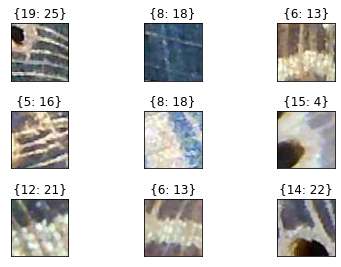

In [ ]:
for i in range (1,10):
    plt.subplot(3,3,i)
    idx = random.randint(0,num_classes*patches_per_species)
    plt.tight_layout()
    plt.imshow(X_train[idx])
    plt.title(('{%d: %s}')%(int(Y_train[idx]), dictLabels[int(Y_train[idx])]))
    plt.xticks([])
    plt.yticks([])
plt.show()


In [ ]:
import math
from keras import layers

from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, LeakyReLU

from helpers import load_hdf5

In [ ]:
def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    
    shortcut = y

    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same', use_bias=False)(y)
    y = layers.LeakyReLU()(y)

    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False)(y)

    if _project_shortcut or _strides != (1, 1):
        shortcut = layers.Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same', use_bias=False)(shortcut)

    y = layers.add([shortcut, y])
    y = layers.LeakyReLU()(y)

    return y


In [ ]:
def getSampleResidualModel2(numClasses, shape):
    
    inputs = Input(shape=shape)
    
    conv1 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(inputs)
    act1 = LeakyReLU(alpha=0.1)(conv1)
    res1 = residual_block(act1, 64);  
    pool1 = MaxPool2D(pool_size=(2,2))(res1)
    
    res2 = residual_block(pool1, 64);  
    pool2 = MaxPool2D(pool_size=(2,2))(res2)
        
    res3 = residual_block(pool2, 64)
    pool3 = MaxPool2D(pool_size=(2,2))(res3)
    
    res4 = residual_block(pool3, 64)
    pool4 = MaxPool2D(pool_size=(2,2))(res4)
    
    flat1 = Flatten()(pool4)
    dens1 = Dense(256, activation='relu')(flat1)
    dens2 = Dense(numClasses, activation = 'softmax')(dens1)
    
    model = Model(inputs=inputs, outputs=dens2)
    model.compile(optimizer="Adam",loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
num_epochs = 1000
batch_size = 32
num_classes = 24
patch_size = 64

best_weights = '/content/drive/MyDrive/best_weights_fold_4.h5'
history_saved = '/content/drive/MyDrive/history_folld4p'

augment = True

In [ ]:
X_train = load_hdf5(train_patches)
Y_train = load_hdf5(train_labels)
Y_train = to_categorical(Y_train)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

In [ ]:
model = getSampleResidualModel2(num_classes, (patch_size, patch_size, 3))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36864       ['leaky_re_lu[0][0]']            
                                                                                              

In [ ]:
model_json = model.to_json()
with open('/content/drive/MyDrive/model.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:

def exp_decay(epoch):
   initial_lrate = 0.1
   k = 0.1
   lrate = initial_lrate * math.exp(-k*epoch)
   return lrate

In [ ]:
checkpointer = ModelCheckpoint(best_weights, verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased
patienceCallBack = EarlyStopping(monitor='val_loss',patience=100)
learningRateCallBack = LearningRateScheduler(exp_decay ,verbose = 1)
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True, profile_batch = 100000000)

In [ ]:
if augment == True:
    
    print('Train with augmentation')
    
    datagen = ImageDataGenerator(
                            rotation_range=10,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
    
    validation_split = 0.2
    indx = list(range(0,len(X_train)))
    random.shuffle(indx)
    random.shuffle(indx)

    k = int(0.2*len(X_train))

    X_val = X_train[indx[0:k]]
    Y_val = Y_train[indx[0:k]]

    X_train = X_train[indx[k:len(X_train)]]
    Y_train = Y_train[indx[k:len(Y_train)]] 

    history = model.fit_generator(datagen.flow(x = X_train, y = Y_train, batch_size = batch_size),
                                  #validation_data = datagen.flow(x = X_val, y = Y_val, batch_size = batch_size),
                                  validation_data = (X_val, Y_val),
                                  steps_per_epoch = len(X_train)/batch_size,
                                  epochs = num_epochs,
                                  #callbacks = [checkpointer,tbCallBack,patienceCallBack])                  
                                  callbacks = [checkpointer,patienceCallBack])        
else:
    
    print('No augmentation')
    
    history = model.fit(x=X_train, 
                    y=Y_train, 
                    validation_split=0.2, 
                    epochs = num_epochs, 
                    batch_size=batch_size, 
                    shuffle=True, 
                    callbacks = [checkpointer,tbCallBack,patienceCallBack])


Train with augmentation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/1000
600/600 [==============================] - ETA: 0s - loss: 2.9326 - accuracy: 0.1165
Epoch 1: val_loss improved from inf to 2.49488, saving model to /content/drive/MyDrive/best_weights_fold_4.h5
600/600 [==============================] - 41s 47ms/step - loss: 2.9326 - accuracy: 0.1165 - val_loss: 2.4949 - val_accuracy: 0.2412
Epoch 2/1000
599/600 [============================>.] - ETA: 0s - loss: 2.2210 - accuracy: 0.3204
Epoch 2: val_loss improved from 2.49488 to 2.02783, saving model to /content/drive/MyDrive/best_weights_fold_4.h5
600/600 [==============================] - 27s 46ms/step - loss: 2.2206 - accuracy: 0.3204 - val_loss: 2.0278 - val_accuracy: 0.3821
Epoch 3/1000
600/600 [==============================] - ETA: 0s - loss: 1.7208 - accuracy: 0.4621
Epoch 3: val_loss improved from 2.02783 to 1.50132, saving model to /content/drive/MyDrive/best_weights_fold_4.h5
600/600 [==============================] - 29s 49ms/step - loss: 1.7208 - accuracy: 0.4621 - val_loss:

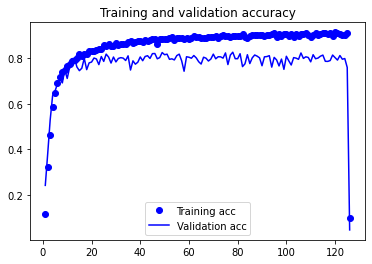

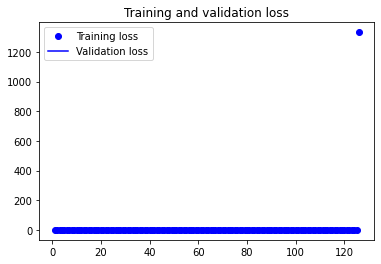

In [ ]:

#-----------------------------------------------------------------------------
#plot train history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

pickle.dump(history, open(history_saved, "wb"))

In [ ]:
from helpers import plot_confusion_matrix
from keras.models import model_from_json

total acc:  77.01451451451452
correct classifications:  6155
errors:  1837


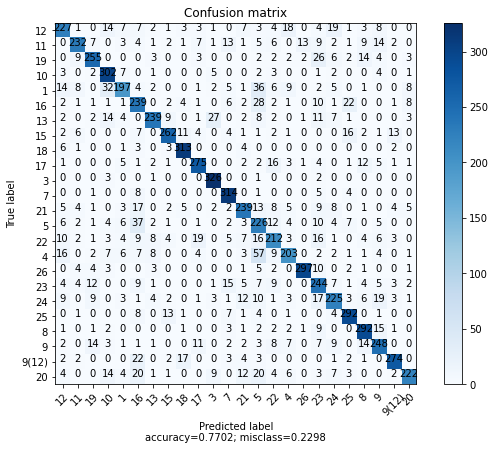

In [ ]:
conf_mat_patches_saved = '/content/drive/MyDrive/conf_mat_patches_fold4.p'
model = model_from_json(open('/content/drive/MyDrive/model.json').read())
model.load_weights(best_weights)

#-----------------------------------------------------------------------------   
#load test data - patches

X_test = load_hdf5(test_patches)

# for i in range(0,X_test.shape[0]):
#      X_test[i] = rotate(X_test[i],90)

Y_test = load_hdf5(test_labels)

#-----------------------------------------------------------------------------   
#predict 

y_pred = model.predict(X_test, batch_size=600)
y_pred = np.argmax(y_pred, axis = 1) 

#-----------------------------------------------------------------------------   
#assess accuracy

total = 0
okays = 0

for i in range(y_pred.shape[0]):
    total += 1
    if (y_pred[i] == Y_test[i]):
        okays += 1
        
print("total acc: ", 100*okays/total)
print("correct classifications: ", okays)
print("errors: ", total - okays)

#-----------------------------------------------------------------------------   
#plot confusion matrix

confusionMatrix = np.zeros((num_classes, num_classes), dtype= 'int')

for i in range(0,Y_test.shape[0]-1):
    
    confusionMatrix[int(Y_test[i])][y_pred[i]] +=1

dict_labels = pickle.load(open('/content/drive/MyDrive/dictLabels.p', "rb"))

names = list()

for i in range(0, num_classes):
    names.append(dict_labels[i])

plot_confusion_matrix(confusionMatrix, normalize=False, target_names = names)
pickle.dump(confusionMatrix, open(conf_mat_patches_saved, "wb"))

In [ ]:
import os
import pickle

import time

import numpy as np
import configparser
from skimage import io

from keras.models import model_from_json
from helpers import plot_confusion_matrix, imagePreprocessing

12
/content/drive/MyDrive/Data_Fold/fold_4/12/WIN_20220826_16_10_35_Pro.jpg
/content/drive/MyDrive/Data_Fold/fold_4/12/WIN_20220826_16_11_12_Pro.jpg
/content/drive/MyDrive/Data_Fold/fold_4/12/WIN_20220826_16_11_22_Pro.jpg
/content/drive/MyDrive/Data_Fold/fold_4/12/WIN_20220826_16_11_43_Pro.jpg
!!!!!!!!!!!!!
/content/drive/MyDrive/Data_Fold/fold_4/12/WIN_20220826_16_11_43_Pro.jpg
3
!!!!!!!!!!!!!
/content/drive/MyDrive/Data_Fold/fold_4/12/WIN_20220826_16_12_06_Pro.jpg
/content/drive/MyDrive/Data_Fold/fold_4/12/WIN_20220826_16_12_14_Pro.jpg
/content/drive/MyDrive/Data_Fold/fold_4/12/WIN_20220826_16_12_22_Pro.jpg
/content/drive/MyDrive/Data_Fold/fold_4/12/WIN_20220826_16_12_31_Pro.jpg
11
/content/drive/MyDrive/Data_Fold/fold_4/11/WIN_20220826_15_10_30_Pro.jpg
/content/drive/MyDrive/Data_Fold/fold_4/11/WIN_20220826_15_10_48_Pro.jpg
/content/drive/MyDrive/Data_Fold/fold_4/11/WIN_20220826_15_10_59_Pro.jpg
/content/drive/MyDrive/Data_Fold/fold_4/11/WIN_20220826_15_12_29_Pro.jpg
/content/drive/

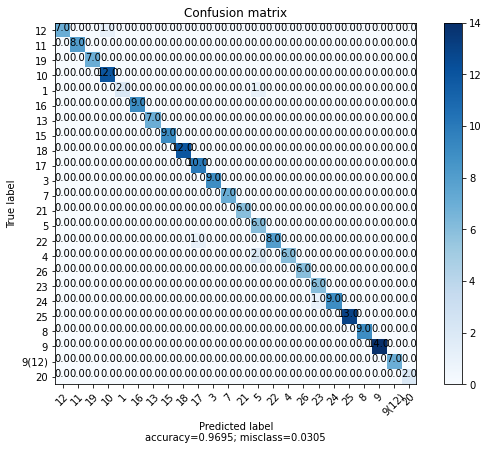

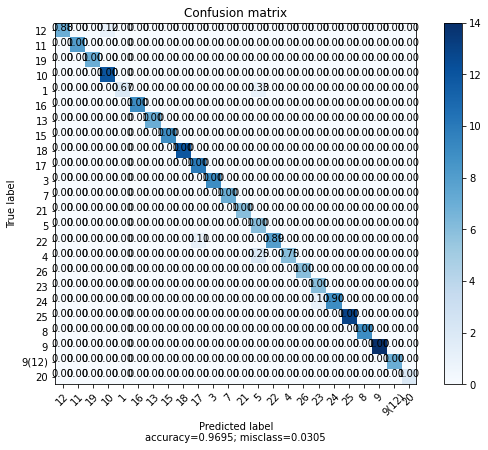

In [ ]:

pred_dir = '/content/drive/MyDrive/Data_Fold/preds_fold4'
test_dir = '/content/drive/MyDrive/Data_Fold/fold_4'
num_classes = 24
patch_size = 64

test_patches = '/content/drive/MyDrive/test_patches_fold_4.hdf'
test_labels = '/content/drive/MyDrive/test_labels_fold_4.hdf'
best_weights = '/content/drive/MyDrive/best_weights_fold_4.h5'
conf_mat_images_saved = '/content/drive/MyDrive/conf_mat_images_fold4.p'
#-----------------------------------------------------------------------------    
#load CNN model

model = model_from_json(open('/content/drive/MyDrive/model.json').read())
model.load_weights(best_weights)

#-----------------------------------------------------------------------------   
# predict image patch by patch
    
def predictImage(img, patchSize,numClasses):
    
    stride = 10
    
    model = model_from_json(open('/content/drive/MyDrive/model.json').read())
    model.load_weights(best_weights)
    
    [rows, cols, nch] = img.shape
        
    out = np.zeros((rows,cols), dtype = 'uint8')
    
    num = (1 + (rows - patchSize)  / stride) * (1 + (cols - patchSize)  / stride)  
    num = int(num+1)
    
    X_test = np.zeros((num, patchSize, patchSize, nch))
    probs = np.zeros((numClasses,1))
    
    y = 0
    patchId = 0;
    
    while y+patchSize < rows:
       
        x = 0
    
        while x+patchSize < cols:
                        
            patch = img[y:y+patchSize,x:x+patchSize]
            X_test[patchId] = patch
            patchId += 1
            x = x + stride

        y = y + stride
    
    #print('--- patches: %d ---' % X_test.shape[0])
    
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis = 1) 
            
    y = 0
    patchId = 0;
     
    while y+patchSize < rows:
       
        x = 0
    
        while x+patchSize < cols:
            
            x1 = int(x+patchSize/2)
            x2 = int(x+patchSize/2) + stride

            y1 = int(y+patchSize/2)
            y2 = int(y+patchSize/2) + stride
               
            out[y1:y2,x1:x2] = 10*y_pred[patchId]
            probs[y_pred[patchId]] +=1
            patchId += 1
            x = x + stride

        y = y + stride    
    
    probs = probs/patchId
    fin = np.argmax(probs) 
    
    return out, fin

#-----------------------------------------------------------------------------  
# predict files in test directory
    
dict_labels = pickle.load(open('/content/drive/MyDrive/dictLabels.p', "rb"))
dict_names = pickle.load(open('/content/drive/MyDrive/dictNames.p', "rb"))

confMat = np.zeros((num_classes,num_classes))

for dirname, dirnames, files in os.walk(test_dir):
    
    for subdir in dirnames:
        
        print(subdir)
            
        classId = dict_names[subdir]
            
        f = os.listdir(os.path.join(dirname, subdir))
        
        for file in f:
            
            img = io.imread(os.path.join(dirname,subdir, file))
            img = img[:,:,0:3]
            print(os.path.join(dirname,subdir, file))
            
            img = imagePreprocessing(img)
            
            start_time = time.time()
            pred, label = predictImage(img, patch_size, num_classes)
            #print("--- %s seconds ---" % (time.time() - start_time))
            #print("--- shape %d x %d pixels ---" % (pred.shape[0], pred.shape[1]))
            
            #print(pred.shape[0], pred.shape[1], (time.time() - start_time))
            
            path = os.path.join(pred_dir,subdir, file)
            io.imsave(path, pred)
            
            confMat[classId,label] +=1
            
            if classId != label:
                print('!!!!!!!!!!!!!')
                print(os.path.join(dirname,subdir, file))
                print(label)
                print('!!!!!!!!!!!!!')
                

names = list()
for i in range(0, num_classes):
    names.append(dict_labels[i])
    
plot_confusion_matrix(confMat, normalize=False, target_names = names)
plot_confusion_matrix(confMat, normalize=True, target_names = names)
pickle.dump(confMat, open(conf_mat_images_saved, "wb"))